In [30]:
#Transfer leraning with Tensorfow part 3 : Scaling up
!nvidia-smi

Fri Feb  2 23:06:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               9W /  80W |   2674MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [31]:
# creating helper functions
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir,compare_historys

In [32]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [33]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [34]:
#Setup Data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=IMG_SIZE,shuffle=False) # dont shuffle test data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [35]:
#create checkpoint callback
checkpoint_path = "transfer_learning/101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,)

In [36]:
#create data augmentation layer to incorporate it into model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


#setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) #Rescale input of images between 0 & 1 , required for model like resnet50
] ,name = "data_augmentation")

In [37]:
# setup the base model and freeze its layers
#005 Creating a headless EfficientNetB0 model with data augmentation built in
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable=False

#Setup model architecuture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="input_layer")
x= data_augmentation(inputs) #augment images (only happens during training phase
x = base_model(x,training=False) # put the base model in inference mode so weights are frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x) # in case of models (like sequential) input go inside model in layers inputs go outside model
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

24274472/24274472 [==============================] - 6s 0us/step


In [38]:
# get summary of model created
model.summary() # transfer learning feature extraction model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [39]:
#006 Fitting and evaluating our biggest transfer learning model yet
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 87s 339ms/step - loss: 3.5199 - accuracy: 0.2399 - val_loss: 2.6752 - val_accuracy: 0.4314
Epoch 2/5
237/237 [==============================] - 72s 302ms/step - loss: 2.4323 - accuracy: 0.4446 - val_loss: 2.1660 - val_accuracy: 0.4984
Epoch 3/5
237/237 [==============================] - 67s 284ms/step - loss: 2.0529 - accuracy: 0.5149 - val_loss: 1.9982 - val_accuracy: 0.5127
Epoch 4/5
237/237 [==============================] - 65s 273ms/step - loss: 1.8467 - accuracy: 0.5533 - val_loss: 1.8902 - val_accuracy: 0.5238
Epoch 5/5
237/237 [==============================] - 63s 267ms/step - loss: 1.6907 - accuracy: 0.5850 - val_loss: 1.8282 - val_accuracy: 0.5281


In [40]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 57s 72ms/step - loss: 1.6372 - accuracy: 0.5686


[1.6371843814849854, 0.5685940384864807]

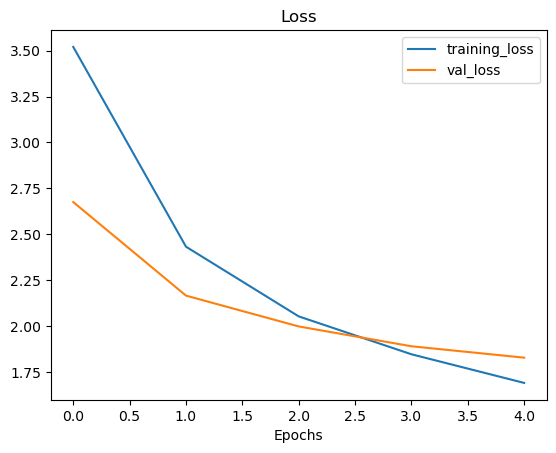

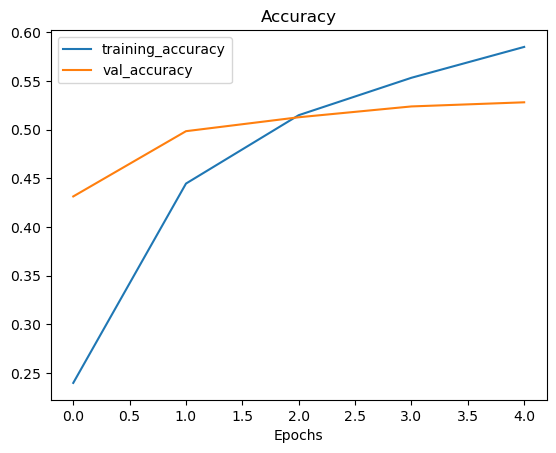

In [41]:
plot_loss_curves(history_all_classes_10_percent)

In [42]:
#007 Unfreezing some layers in our base model to prepare for fine-tuning
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last file
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [43]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [44]:
#008 Fine-tuning our feature extraction model and evaluating its performance
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10


237/237 [==============================] - 73s 271ms/step - loss: 1.4658 - accuracy: 0.6391 - val_loss: 1.7919 - val_accuracy: 0.5254
Epoch 6/10
237/237 [==============================] - 63s 264ms/step - loss: 1.3738 - accuracy: 0.6512 - val_loss: 1.8013 - val_accuracy: 0.5249
Epoch 7/10
237/237 [==============================] - 62s 260ms/step - loss: 1.3228 - accuracy: 0.6540 - val_loss: 1.7917 - val_accuracy: 0.5286
Epoch 8/10
237/237 [==============================] - 62s 260ms/step - loss: 1.2720 - accuracy: 0.6737 - val_loss: 1.7641 - val_accuracy: 0.5344
Epoch 9/10
237/237 [==============================] - 61s 257ms/step - loss: 1.2408 - accuracy: 0.6675 - val_loss: 1.7955 - val_accuracy: 0.5328
Epoch 10/10
237/237 [==============================] - 60s 254ms/step - loss: 1.2054 - accuracy: 0.6735 - val_loss: 1.7872 - val_accuracy: 0.5273


In [45]:
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results

790/790 [==============================] - 56s 71ms/step - loss: 1.5128 - accuracy: 0.5927


[1.5127532482147217, 0.5926732420921326]

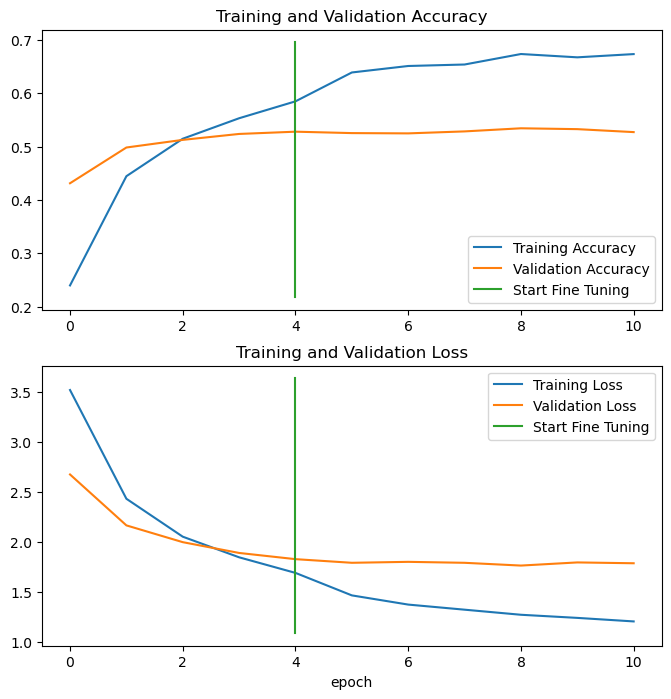

In [46]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
#009 Saving and loading our trained model
#Saving and loading our model
model.save("saved_models/101_food_classes_10_percent")
#model.save("saved_models/101_food_classes_10_percent")

In [50]:
loaded_model = tf.keras.models.load_model("saved_models/101_food_classes_10_percent")

In [51]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 59s 73ms/step - loss: 1.5128 - accuracy: 0.5927


[1.5127532482147217, 0.5926732420921326]

In [ ]:
#010 Downloading a pretrained model to make and evaluate predictions with